### Multimodal RAG (PDF With Images)

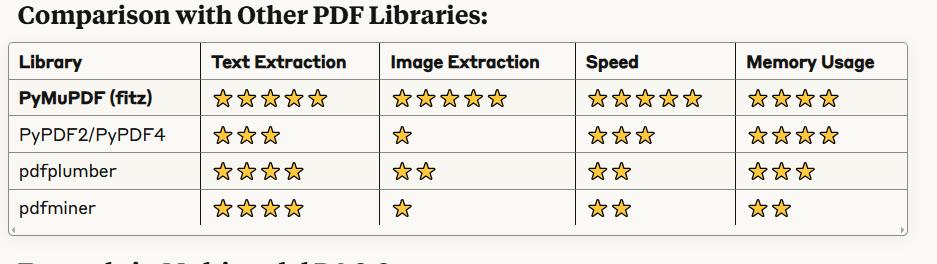

In [1]:
import fitz  # PyMuPDF
from langchain_core.documents import Document
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import numpy as np
from langchain.chat_models import init_chat_model
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage
from sklearn.metrics.pairwise import cosine_similarity
import os
import base64
import io
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS

d:\Data_Science_stuff\Krish_naik_classes\AgenticAI_GenAI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CLIP is crucial because it can embed both text and images into the same latent space, enabling cross-modal retrieval.

🔎 What is CLIP?

**CLIP (Contrastive Language–Image Pretraining)** is a model by OpenAI that learns to connect text and images.

- It’s trained on hundreds of millions of image–caption pairs.
- The key idea: map text and images into the same vector space so that related ones land close together.
- Example: The text “a cat sitting on a sofa” and an image of a cat on a sofa → both get embeddings that are similar.

This makes CLIP ideal for multimodal tasks like:

- Image search with text queries (or vice versa).
- Captioning and cross-modal retrieval.

🛠 **Why Do We Need Both** CLIPModel and CLIPProcessor?

1. CLIPModel

    - The neural network itself.
    - It has two encoders:
        - Text Encoder: turns text into embeddings.
        - Image Encoder: turns images into embeddings.
    - Provides outputs like logits or embeddings.

2. CLIPProcessor

    - Handles all the preprocessing needed before passing data into the model.
    - For text:
        - Tokenization (converting words into IDs).
    - For images:
        - Resizing, normalization, converting to tensors.
        - Also pads, batches, and formats the inputs in exactly the way CLIP expects.

    👉 Without the Processor, we’d have to manually replicate OpenAI’s preprocessing pipeline (pixel normalization, tokenization, padding).

In [ ]:
### Clip Model
import os
from dotenv import load_dotenv
load_dotenv()

## set up the environment
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

### initialize the Clip Model for unified embeddings
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()


'''
The model used here is:
"openai/clip-vit-base-patch32"

This means:
- Architecture: Vision Transformer (ViT)
- Base size: small-medium model
- Patch size: 32×32 pixels
'''

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


'\nThe model used here is:\n\n"openai/clip-vit-base-patch32"\nThis means:\n\nArchitecture: Vision Transformer (ViT)\n\nBase size: small-medium model\n\nPatch size: 32×32 pixels\n'

1️⃣ clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

- Loads the CLIP model from HuggingFace's model hub.
- This model contains two encoders:
    - An image encoder
    - A text encoder
- Both encoders map inputs into a shared embedding space for similarity comparison.

2️⃣ clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

- Loads the preprocessing pipeline that:
    - Tokenizes and processes text
    - Resizes and normalizes images
- It ensures that both the image and text are transformed correctly before being passed into the model.

3️⃣ clip_model.eval()

- Puts the model in evaluation (inference) mode.
- This:
    - Disables training behaviors (e.g., dropout, batchnorm updates)
    - Ensures consistent outputs during inference

In [3]:
### Embedding functions
def embed_image(image_data):
    """Embed image using CLIP"""
    if isinstance(image_data, str):  # If image is a file path
        image = Image.open(image_data).convert("RGB")
    else:  # If PIL Image
        image = image_data
    
    inputs=clip_processor(images=image, return_tensors="pt") # uses CLIPProcessor to preprocess the image: resize, normalize, convert to tensor.
    with torch.no_grad():
        features = clip_model.get_image_features(**inputs)
        # Normalize embeddings to unit vector
        features = features / features.norm(dim=-1, keepdim=True) # Normalizes the vector to unit length (L2 norm = 1). This is crucial for cosine similarity tasks.
        return features.squeeze().numpy() # Converts the tensor to a NumPy array (e.g., shape [512] or [768] or [1024] depending on model
    




def embed_text(text):
    """Embed text using CLIP."""
    inputs = clip_processor(  # Tokenizes and pads the text for CLIP.
        text=text, 
        return_tensors="pt", 
        padding=True,
        truncation=True,
        max_length=77  # CLIP's max token length
    )
    with torch.no_grad():
        # Passes tokenized text to the CLIP text encoder to get embedding
        features = clip_model.get_text_features(**inputs) 
        # Normalizes to a unit vector
        features = features / features.norm(dim=-1, keepdim=True)
        # Converts to NumPy array for further use
        return features.squeeze().numpy()

| Function        | Input Type           | Output            | Purpose                        |
| --------------- | -------------------- | ----------------- | ------------------------------ |
| `embed_image()` | File path or PIL Img | Normalized vector | Encode images into CLIP vector |
| `embed_text()`  | String or List       | Normalized vector | Encode text into CLIP vector   |


In [4]:
## Process PDF
pdf_path = "multimodal_sample.pdf"
doc = fitz.open(pdf_path)
# Storage for all documents and embeddings
all_docs = []
all_embeddings = []
image_data_store = {}  # Store actual image data for LLM

# Text splitter
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)


In [5]:
doc

Document('multimodal_sample.pdf')

Now in below section for each page in the PDF, we are performing below stuff:

- Extract text, split it into chunks, and embed each chunk using embed_text() (CLIP).
- Extract images, convert to base64 for GPT-4V, embed using embed_image() (CLIP), and store both metadata and image.

In [8]:
for i,page in enumerate(doc):
    ## process text - Extract text from the current page.
    text=page.get_text()
    if text.strip():
        ##create temporary document for splitting
        temp_doc = Document(page_content=text, metadata={"page": i, "type": "text"})
        text_chunks = splitter.split_documents([temp_doc])

        # Embed each chunk using CLIP and generate CLIP text embedding
        # Append embedding to all_embeddings list and the chunk to all_docs
        for chunk in text_chunks:
            embedding = embed_text(chunk.page_content)
            all_embeddings.append(embedding)
            all_docs.append(chunk)



    ## process images
    ##Three Important Actions:

    ##Convert PDF image to PIL format
    ##Store as base64 for GPT-4V (which needs base64 images)
    ##Create CLIP embedding for retrieval

    for img_index, img in enumerate(page.get_images(full=True)):
        try:
            # Get image bytes using the image reference (xref) and extract_image()
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            
            # Convert raw image bytes into a PIL image (for embedding and processing)
            pil_image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
            
            # Create unique identifier
            image_id = f"page_{i}_img_{img_index}"
            
            # Store image as base64 for later use with GPT-4V which take Base64 image inputs
            buffered = io.BytesIO()
            pil_image.save(buffered, format="PNG")
            img_base64 = base64.b64encode(buffered.getvalue()).decode()
            image_data_store[image_id] = img_base64
            
            # Embed image using CLIP
            embedding = embed_image(pil_image)
            all_embeddings.append(embedding)
            
            # Create document for image
            image_doc = Document(
                page_content=f"[Image: {image_id}]",
                metadata={"page": i, "type": "image", "image_id": image_id}
            )
            all_docs.append(image_doc)
            
        except Exception as e:
            print(f"Error processing image {img_index} on page {i}: {e}")
            continue

doc.close()


## Final Outputs

# - all_docs — List of LangChain Document objects (text + image placeholders)
# - all_embeddings — List of CLIP vector embeddings (text + image)
# - image_data_store — Dict mapping image IDs to base64 images (for GPT-4 Vision)

ValueError: document closed

In [ ]:
all_docs

[Document(metadata={'page': 0, 'type': 'text'}, page_content='Annual Revenue Overview\nThis document summarizes the revenue trends across Q1, Q2, and Q3. As illustrated in the chart\nbelow, revenue grew steadily with the highest growth recorded in Q3.\nQ1 showed a moderate increase in revenue as new product lines were introduced. Q2 outperformed\nQ1 due to marketing campaigns. Q3 had exponential growth due to global expansion.'),
 Document(metadata={'page': 0, 'type': 'image', 'image_id': 'page_0_img_0'}, page_content='[Image: page_0_img_0]')]

In [9]:
all_embeddings

[array([-2.67245458e-03,  1.28299929e-02, -5.18314242e-02,  4.14879546e-02,
        -2.33942140e-02, -7.55862752e-03, -3.67659330e-02,  1.19710743e-01,
         8.52081105e-02,  2.05422984e-03, -1.11534633e-02, -1.29592279e-02,
         5.25014885e-02, -3.65396473e-03,  4.76078466e-02,  1.58373099e-02,
         2.03388333e-02,  4.35361974e-02, -3.29167070e-03,  2.03181170e-02,
         1.88026356e-03, -4.23493870e-02,  5.44103701e-03,  3.70935686e-02,
        -1.65622830e-02,  6.48646057e-03, -4.78012338e-02,  8.67480133e-03,
         5.88860102e-02, -3.21394391e-02,  4.32440080e-02,  9.65300016e-03,
        -4.47921129e-03, -1.94858070e-02, -3.63502800e-02, -1.23471869e-02,
        -2.17929240e-02, -1.99016538e-02,  8.09620321e-02, -3.32986899e-02,
        -2.38901246e-02, -3.96138839e-02, -1.27280336e-02,  3.50380950e-02,
        -2.52217147e-02,  2.00032652e-03,  1.49660530e-02, -2.31976546e-02,
        -6.86791241e-02, -5.25798881e-04, -2.22546123e-02, -1.04103889e-02,
        -1.9

In [10]:
# Create unified FAISS vector store with CLIP embeddings
embeddings_array = np.array(all_embeddings)
embeddings_array

array([[-0.00267245,  0.01282999, -0.05183142, ..., -0.00385085,
         0.02977721, -0.00010685],
       [ 0.01732339, -0.01327691, -0.02427031, ...,  0.08994055,
        -0.00272157,  0.03253039]], shape=(2, 512), dtype=float32)

In [11]:
(all_docs, embeddings_array)

([Document(metadata={'page': 0, 'type': 'text'}, page_content='Annual Revenue Overview\nThis document summarizes the revenue trends across Q1, Q2, and Q3. As illustrated in the chart\nbelow, revenue grew steadily with the highest growth recorded in Q3.\nQ1 showed a moderate increase in revenue as new product lines were introduced. Q2 outperformed\nQ1 due to marketing campaigns. Q3 had exponential growth due to global expansion.'),
  Document(metadata={'page': 0, 'type': 'image', 'image_id': 'page_0_img_0'}, page_content='[Image: page_0_img_0]')],
 array([[-0.00267245,  0.01282999, -0.05183142, ..., -0.00385085,
          0.02977721, -0.00010685],
        [ 0.01732339, -0.01327691, -0.02427031, ...,  0.08994055,
         -0.00272157,  0.03253039]], shape=(2, 512), dtype=float32))

In [12]:
# Create custom FAISS index since we have precomputed embeddings
vector_store = FAISS.from_embeddings(
    text_embeddings=[(doc.page_content, emb) for doc, emb in zip(all_docs, embeddings_array)],
    embedding=None,  # since we already computed embeddings via CLIP, we pass None
    metadatas=[doc.metadata for doc in all_docs]
)
vector_store

`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


In [ ]:
# Initialize GPT-4 Vision model
# The init_chat_model() function is a LangChain utility that automatically initializes a chat model 
# based on a string specifier — like "openai:gpt-4.1"
llm = init_chat_model("openai:gpt-4.1")
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001B1C29BA3C0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001B1C29BAE40>, root_client=<openai.OpenAI object at 0x000001B1C280B4D0>, root_async_client=<openai.AsyncOpenAI object at 0x000001B1C29BABA0>, model_name='gpt-4.1', model_kwargs={}, openai_api_key=SecretStr('**********'))

In [14]:
'''
This function retrieves top-k most similar documents from the vector store.
These documents can be either text chunks or images — both have embeddings created by CLIP.

This allows us to:
- Search image+text together using just a text query
- Get back either text snippets or relevant images
- Use it for GPT-4V-based question answering (pass retrieved base64 image + text chunks)
'''

def retrieve_multimodal(query, k=5):
    """Unified retrieval using CLIP embeddings for both text and images."""
    # Embed query using CLIP
    query_embedding = embed_text(query)
    
    # Search in unified vector store
    results = vector_store.similarity_search_by_vector(
        embedding=query_embedding,
        k=k
    )
    
    return results

In [15]:
'''
Summary

This function constructs a rich multimodal prompt combining:
- Relevant text
- Matching images
- A clear question
- A final instruction

It’s essential for multimodal RAG systems using GPT-4V, enabling the model to reason jointly over both text and visuals.
'''

def create_multimodal_message(query, retrieved_docs):
    """Create a message with both text and images for GPT-4V."""
    content = []
    
    # Add the query
    content.append({
        "type": "text",
        "text": f"Question: {query}\n\nContext:\n"
    })
    
    # Separate text and image documents
    text_docs = [doc for doc in retrieved_docs if doc.metadata.get("type") == "text"]
    image_docs = [doc for doc in retrieved_docs if doc.metadata.get("type") == "image"]
    
    # Add text context
    # Each retrieved text chunk is appended along with the page number.
    # Result is one consolidated "type": "text" block with helpful context for the LLM.
    if text_docs:
        text_context = "\n\n".join([
            f"[Page {doc.metadata['page']}]: {doc.page_content}"
            for doc in text_docs
        ])
        content.append({
            "type": "text",
            "text": f"Text excerpts:\n{text_context}\n"
        })
    
    # Add images
    # For each image document:
    # - Adds a text caption: [Image from page 2]
    # - Then adds the actual image in base64 format (as data:image/png;base64,...)
    # This format is supported by GPT-4V and other Vision-enabled models via LangChain
    for doc in image_docs:
        image_id = doc.metadata.get("image_id")
        if image_id and image_id in image_data_store:
            content.append({
                "type": "text",
                "text": f"\n[Image from page {doc.metadata['page']}]:\n"
            })
            content.append({
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/png;base64,{image_data_store[image_id]}"
                }
            })
    
    # Adds a final instruction guiding the model on what to do with the inputs
    content.append({
        "type": "text",
        "text": "\n\nPlease answer the question based on the provided text and images."
    })
    
    return HumanMessage(content=content)

In [ ]:
def multimodal_pdf_rag_pipeline(query):
    """Main pipeline for multimodal RAG."""
    
    # Retrieve relevant documents
    # Calls the earlier-defined retrieve_multimodal() function.
    # Embeds the query using CLIP, and performs vector similarity search in the FAISS store.
    # It returns top-k most relevant documents (can be text or images).
    context_docs = retrieve_multimodal(query, k=5)
    
    # Create multimodal message
    # Takes the retrieved documents and query.
    # Constructs a HumanMessage object containing:
    #   - text: User's question
    #   - text: Textual context from PDF
    #   - image_url: Embedded base64 image previews
    #   - text: Final instruction like “Please answer...”
    # This is formatted specifically for GPT-4 Vision.
    message = create_multimodal_message(query, context_docs)
    
    # Get response from GPT-4V
    # Sends the full multimodal prompt to the LLM (likely gpt-4-vision).
    # Returns a structured or free-form answer, depending on the prompt.
    # response.content contains the actual final answer.
    response = llm.invoke([message])
    
    # Print retrieved context info
    # This gives a preview of the retrieved context:
    #   - If text, it prints the first 100 characters
    #   - If image, it prints the page number it came from
    # This helps in verifying whether retrieval was relevant or not.
    print(f"\nRetrieved {len(context_docs)} documents:")
    for doc in context_docs:
        doc_type = doc.metadata.get("type", "unknown")
        page = doc.metadata.get("page", "?")
        if doc_type == "text":
            preview = doc.page_content[:100] + "..." if len(doc.page_content) > 100 else doc.page_content
            print(f"  - Text from page {page}: {preview}")
        else:
            print(f"  - Image from page {page}")
    print("\n")
    
    return response.content

In [17]:
if __name__ == "__main__":
    # Example queries
    queries = [
        "What does the chart on page 1 show about revenue trends?",
        "Summarize the main findings from the document",
        "What visual elements are present in the document?"
    ]
    
    for query in queries:
        print(f"\nQuery: {query}")
        print("-" * 50)
        answer = multimodal_pdf_rag_pipeline(query)
        print(f"Answer: {answer}")
        print("=" * 70)


Query: What does the chart on page 1 show about revenue trends?
--------------------------------------------------

Retrieved 2 documents:
  - Text from page 0: Annual Revenue Overview
This document summarizes the revenue trends across Q1, Q2, and Q3. As illust...
  - Image from page 0


Answer: The chart on page 1 shows a clear upward trend in revenue over the first three quarters of the year. Specifically, revenue increases steadily from Q1 to Q2, and there is a significant jump in Q3. This matches the text, which states that revenue grew moderately in Q1, increased further in Q2 due to marketing campaigns, and then experienced exponential growth in Q3 as a result of global expansion. Overall, the chart visually confirms that revenue growth accelerated across each quarter, with the highest increase occurring in Q3.

Query: Summarize the main findings from the document
--------------------------------------------------

Retrieved 2 documents:
  - Text from page 0: Annual Revenue Over